In [9]:
import pandas as pd
import re
import csv
import numpy as np
#import sklearn as skl
#from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as dataset
import torch.optim as optim

import seaborn as sb

import json

# 预处理

In [2]:
# 导入技能、收入数据
skillJobData = pd.read_pickle('./data/kate_data/PNAS_workerdataframe_v4.pkl')

In [3]:
# 所有技能
all_skills = skillJobData.skills

all_skill_keys = {}

# 获取不重复的、所有技能的词汇表
for skill_list in all_skills:
    for skill in skill_list:
        for skill_word in re.split('-|/', skill):
            if skill_word in all_skill_keys:
                all_skill_keys[skill_word] += 1
            else:
                all_skill_keys[skill_word] = 1
            

In [25]:
# 所有技能
all_skills = skillJobData.skills

all_skill_keys = {}

# 获取不重复的、所有技能的词汇表
for skill_list in all_skills:
    for skill in skill_list:
        if skill.lower() in all_skill_keys:
            all_skill_keys[skill.lower()] += 1
        else:
            all_skill_keys[skill.lower()] = 1
            

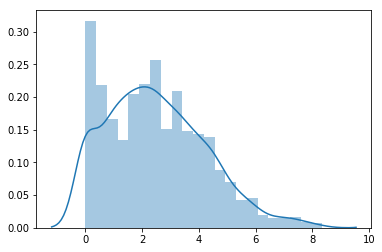

In [26]:
# 查看数据分布
sb.distplot(np.log(np.array(list(all_skill_keys.values()))))

In [27]:
len(all_skill_keys.values())

2197

In [28]:
# 清除出现次数<3的技能
n_count = 0
skill_index = {} #技能编码

for skill, count in zip(all_skill_keys.keys(), all_skill_keys.values()):
    if count > 3:
        skill_index[skill] = n_count
        n_count += 1

print('total skills', n_count)

# 存储为json文件
skill_json = json.dumps(skill_index)
f = open("./data/all_skills.json","w")
f.write(skill_json)
f.close()

total skills 1612


# 构建训练集

In [62]:
def skill2index(skill_list):
    indexs = []
    for skill in skill_list:
        if (skill in skill_index):
            indexs.append(skill_index[skill])
    return indexs

In [64]:
skill2index(['css','html'])

[74, 39]

In [92]:
incomes = skillJobData.log_realized_wage # 所有人收入

skill_index_list = list(map(skill2index, all_skills))
income_list = list(incomes)

trainingData = pd.DataFrame({'skill_indexs':skill_index_list, 'log_income':income_list}) #构建数据集
trainingData = trainingData.dropna() #清除NaN
trainingData = trainingData[trainingData['skill_indexs'].apply(lambda x: len(x)>0)] #清除无技能者

trainingData.to_pickle('./data/training.pkl')

# 导入训练集

In [94]:
trainingData = pd.read_pickle('./data/training.pkl')

In [96]:
trainingData[1:10]

,skill_indexs,log_income
1,"[10, 11, 12, 4, 13, 14, 15, 16, 17]",2.498563
2,[18],3.178054
3,"[19, 20, 21, 22]",2.407846
5,"[27, 28, 29, 30, 31, 32, 33, 34]",1.673976
6,"[35, 36, 37, 38, 39, 40, 15, 7, 8]",1.187843
7,"[27, 41, 42, 33, 43, 22, 44, 8, 45, 9]",2.630089
8,"[30, 46, 47, 22, 48, 49]",2.484907
10,"[11, 52, 13, 53, 54, 55, 56, 57]",3.443512
11,"[58, 59, 60, 61, 42, 33, 62, 63, 64]",1.463255
